# EDA & Data Cleaning
-  Brent Oil Price EDA & Data Cleaning
-  Task 2: Change Point Modeling Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# Set plot style
sns.set_style("whitegrid")
sns.set_palette("husl")

print("🚀 Starting Brent Oil Price Data Loading and EDA...\n")

🚀 Starting Brent Oil Price Data Loading and EDA...



# 1. DATA LOADING

In [4]:
# Load the dataset
# Note: The file has no header; columns are 'Date' and 'Price'
try:
    df = pd.read_csv("../data/raw/BrentOilPrices.csv", header=None, names=['Date', 'Price'])
except FileNotFoundError:
    raise FileNotFoundError("Please ensure 'BrentOilPrices.csv' is in the current directory.")

print(f"✅ Data loaded successfully.")
print(f"   → Shape: {df.shape}")
print(f"   → Date range: {df['Date'].iloc[0]} to {df['Date'].iloc[-1]}")

✅ Data loaded successfully.
   → Shape: (9012, 2)
   → Date range: Date to Nov 14, 2022


In [6]:
# Remove rows where Date is 'Date' or invalid
df = df[df['Date'] != 'Date']  # Remove any row with "Date" as value
df = df.dropna().reset_index(drop=True)

print(f"✅ Removed 'Date' headers. New shape: {df.shape}")

✅ Removed 'Date' headers. New shape: (9011, 2)


# 2. CLEAN DATE COLUMN

In [7]:
def parse_date(date_str):
    """Robust date parser for both formats"""
    # Remove quotes and whitespace
    date_str = str(date_str).strip().replace('"', '')
    
    try:
        # Try old format: 20-May-87
        return pd.to_datetime(date_str, format='%d-%b-%y')
    except:
        try:
            # Try new format: May 26, 2020
            return pd.to_datetime(date_str, format='%b %d, %Y')
        except:
            # If both fail, return NaT (Not a Time)
            return pd.NaT

df['Date'] = df['Date'].apply(parse_date)

# Drop invalid dates
invalid_count = df['Date'].isna().sum()
df = df.dropna(subset=['Date']).reset_index(drop=True)
if invalid_count > 0:
    print(f"🧹 Removed {invalid_count} rows with invalid date formats.")

# 3. CLEAN PRICE COLUMN

In [8]:
# Convert Price to numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.dropna(subset=['Price']).reset_index(drop=True)

print(f"✅ Data types after cleaning:")
print(f"   Date: {df['Date'].dtype}")
print(f"   Price: {df['Price'].dtype}")
print(f"✅ Final shape: {df.shape}")

✅ Data types after cleaning:
   Date: datetime64[ns]
   Price: float64
✅ Final shape: (9011, 2)


In [9]:
# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

# Remove duplicates
duplicates = df.duplicated(subset=['Date']).sum()
if duplicates > 0:
    df = df.drop_duplicates(subset=['Date'], keep='first')
    print(f"🧹 Removed {duplicates} duplicate dates.")


# 4. FEATURE ENGINEERING

In [10]:
print("\n📊 Computing log returns for volatility analysis...")

# Compute log returns
df['Log_Return'] = np.log(df['Price']) - np.log(df['Price'].shift(1))
df['Simple_Return'] = df['Price'].pct_change()
df['Rolling_Volatility'] = df['Log_Return'].rolling(window=30).std()  # 30-day rolling volatility

# Drop first row
df_clean = df.dropna().copy()
print(f"✅ Added features: Log_Return, Simple_Return, Rolling_Volatility")


📊 Computing log returns for volatility analysis...
✅ Added features: Log_Return, Simple_Return, Rolling_Volatility


# 5. EXPLORATORY DATA ANALYSIS (EDA)


🔍 Performing Exploratory Data Analysis...


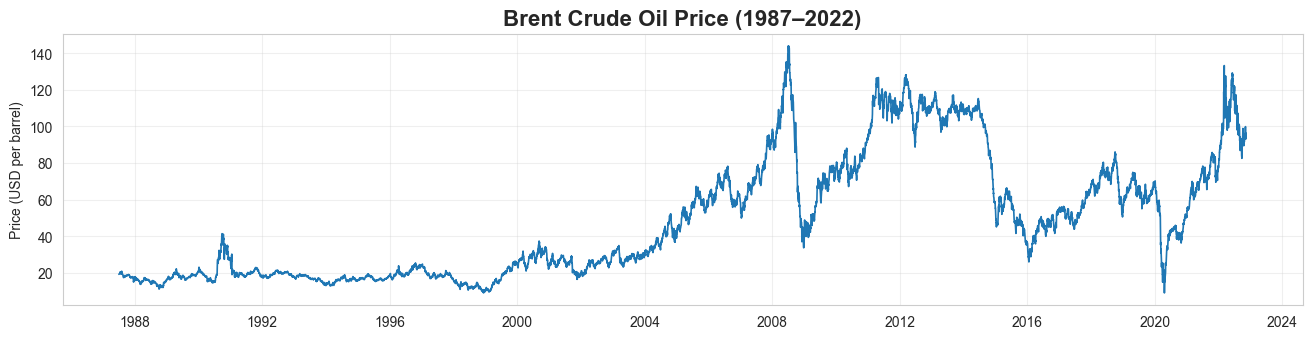

In [11]:
print("\n🔍 Performing Exploratory Data Analysis...")

fig = plt.figure(figsize=(16, 12))

# ----------------------------
# Plot 1: Price Over Time
# ----------------------------
plt.subplot(3, 1, 1)
plt.plot(df_clean['Date'], df_clean['Price'], color='tab:blue', linewidth=1.2)
plt.title("Brent Crude Oil Price (1987–2022)", fontsize=16, fontweight='bold')
plt.ylabel("Price (USD per barrel)")
plt.grid(True, alpha=0.3)

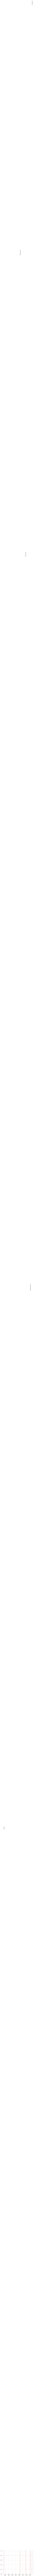

In [12]:
# Add key event markers
events = {
    '1990-08-02': 'Gulf War',
    '2008-09-15': 'Financial Crisis',
    '2014-11-27': 'OPEC No-Cut',
    '2020-03-08': 'Russia-Saudi War',
    '2022-02-24': 'Ukraine War'
}
for date, label in events.items():
    try:
        event_date = pd.to_datetime(date)
        close_data = df_clean[df_clean['Date'] <= event_date].tail(1)
        if not close_data.empty:
            price = close_data['Price'].values[0]
            plt.axvline(event_date, color='red', linestyle='--', alpha=0.7)
            plt.text(event_date, price + 10, label, rotation=90, va='bottom', fontsize=9)
    except:
        continue

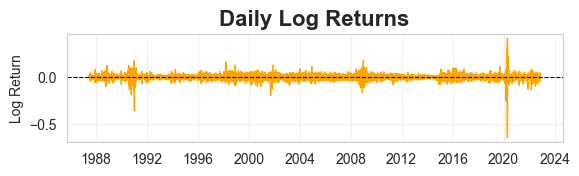

In [13]:
# Plot 2: Log Returns
# ----------------------------
plt.subplot(3, 1, 2)
plt.plot(df_clean['Date'], df_clean['Log_Return'], color='orange', linewidth=1)
plt.title("Daily Log Returns", fontsize=16, fontweight='bold')
plt.ylabel("Log Return")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True, alpha=0.3)

✅ Saved EDA plot: brent_oil_eda_summary.png


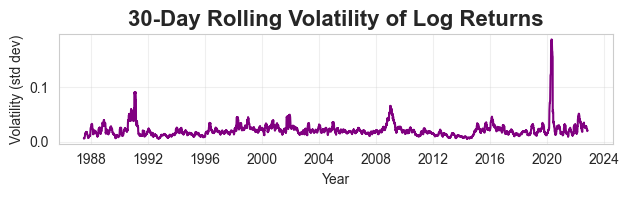

In [14]:
# Plot 3: Rolling Volatility
# ----------------------------
plt.subplot(3, 1, 3)
plt.plot(df_clean['Date'], df_clean['Rolling_Volatility'], color='purple', linewidth=1.5)
plt.title("30-Day Rolling Volatility of Log Returns", fontsize=16, fontweight='bold')
plt.ylabel("Volatility (std dev)")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("brent_oil_eda_summary.png", dpi=300, bbox_inches='tight')
print("✅ Saved EDA plot: brent_oil_eda_summary.png")
plt.show()

# 6. STATIONARITY TEST

In [15]:
print("\n📈 Statistical Summary:")
print(df_clean[['Price', 'Log_Return']].describe())

print("\n🧪 ADF Test on Log Returns (Stationarity Check):")
adf_result = adfuller(df_clean['Log_Return'])
print(f"   ADF Statistic: {adf_result[0]:.6f}")
print(f"   p-value: {adf_result[1]:.6f}")

if adf_result[1] < 0.01:
    print("✅ Log returns are stationary (p < 0.01) → Suitable for modeling.")
else:
    print("⚠️  Log returns may not be stationary.")


📈 Statistical Summary:
             Price   Log_Return
count  8981.000000  8981.000000
mean     48.519762     0.000178
std      32.870215     0.025571
min       9.100000    -0.643699
25%      19.100000    -0.011222
50%      39.050000     0.000395
75%      70.360000     0.012197
max     143.950000     0.412023

🧪 ADF Test on Log Returns (Stationarity Check):
   ADF Statistic: -16.394717
   p-value: 0.000000
✅ Log returns are stationary (p < 0.01) → Suitable for modeling.


# 7. SAVE CLEANED DATA

In [16]:
import os
os.makedirs("../data/processed", exist_ok=True)
output_path = "../data/processed/cleaned_brent_data.csv"
df_clean.to_csv(output_path, index=False)
print(f"\n✅ Cleaned data saved to: {output_path}")


✅ Cleaned data saved to: ../data/processed/cleaned_brent_data.csv


# 8. FINAL SUMMARY

In [17]:
print("\n" + "="*60)
print("✅ EDA & DATA CLEANING COMPLETE")
print("="*60)
print(f"📅 Date Range: {df_clean['Date'].min():%Y-%m-%d} to {df_clean['Date'].max():%Y-%m-%d}")
print(f"📊 Total Days: {len(df_clean)}")
print(f"📉 Min Price: ${df_clean['Price'].min():.2f}")
print(f"📈 Max Price: ${df_clean['Price'].max():.2f}")
print(f"🎯 Mean Price: ${df_clean['Price'].mean():.2f}")
print(f"🧮 Volatility (Std of Log Returns): {df_clean['Log_Return'].std():.6f}")
print(f"🔍 Detected volatility clustering — ideal for change point analysis.")
print("="*60)


✅ EDA & DATA CLEANING COMPLETE
📅 Date Range: 1987-07-02 to 2022-11-14
📊 Total Days: 8981
📉 Min Price: $9.10
📈 Max Price: $143.95
🎯 Mean Price: $48.52
🧮 Volatility (Std of Log Returns): 0.025571
🔍 Detected volatility clustering — ideal for change point analysis.
